# Reliability pattern classifier 

This nb builds on results recorded on [this Confluence page](https://dat.jeppesen.com/confluence/display/RDS/Reliability+classification%3A+data+and+expected+result)

There are two key ideas here that make the problem harder: 

1. Allowing for more noise to drown the signal. In previous cases, we added a noise array of equal length to the simulated data, and allowed for only minor reshuffling of the data points. In practice, this doesn't do very much to obscure the signal. So in this nb, we allow for the noise data points to outnumber the signal points. 
1. Taking inspiration from the three-parameter Weibull distribution, and the [translation invariance of CNNs](https://stats.stackexchange.com/a/208949/56828), we set up the problem so that the classifier has to learn identify the "shape" of a STOW feature, regardless of where on the x-axis that shape shows up. This way it can't rely on simple summary stats to differentiate the classes. 


**With these changes, the baseline classifiers tend to get test-set F1 scores for STOW in the range 0.51 to 0.89.**


In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from scipy.stats import weibull_min, uniform
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split
import seaborn as sns 
from sklearn.datasets import make_classification
import xgboost as xgb

np.random.seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
n_samples = 5000
stow_prop = 0.10  # Values tried: 0.10, 0.20 
n_stow = math.ceil(n_samples * stow_prop)
n_wo = n_samples - n_stow 
# n_null = n_samples - (n_stow + n_wo)  # todo: try multi-class problem with STOW, WO, NULL labels 

null_sample_size_range = [150, 300]  # Values tried: [150, 300], [100, 250]
non_null_sample_size_range = [30, 50]

shape_wo_range = [1.25, 2.0]  # Values tried: [1.25 2.0], [2.0, 4,0]
shape_stow_range = [0.6, 0.9]

noise_max = 300  # pretty arbitrary 

loc_stow_min = 0
loc_stow_max = noise_max * 0.8  # pretty arbitrary 

n_hist_bins = 15 # pretty arbitrary 

In [3]:
n_wo

4500

In [4]:
n_stow

500

In [5]:
data_samples_wo = []
add_noise = True

for sample in range(n_wo): 
    n_non_null_points = np.random.randint(non_null_sample_size_range[0], non_null_sample_size_range[1])
    print(f'{n_non_null_points}--')

    shape_wo = np.random.uniform(shape_wo_range[0], shape_wo_range[1])
    non_null_points = weibull_min.rvs(c=shape_wo, scale=100, size=n_non_null_points)  # todo: should we vary the scale in the case where no noise? 
    
    if add_noise: 
        n_null_points = np.random.randint(null_sample_size_range[0], null_sample_size_range[1])
        null_points = uniform.rvs(loc=0, scale=noise_max, size=n_null_points)
        print(n_null_points)
        data_samples_wo.append(np.concatenate((null_points, non_null_points), axis=0))
    else: 
        data_samples_wo.append(non_null_points)
        
y_wo = np.zeros(shape=n_wo)

36--
279
30--
296
49--
187
44--
171
46--
197
41--
180
47--
184
43--
262
30--
209
36--
183
30--
242
49--
258
47--
206
40--
236
32--
286
40--
260
35--
293
33--
196
46--
168
31--
239
40--
299
36--
246
35--
164
41--
259
36--
252
39--
290
37--
247
46--
210
34--
232
35--
156
31--
230
38--
181
37--
174
30--
175
46--
282
39--
238
34--
280
43--
160
48--
235
42--
260
48--
245
46--
263
39--
227
37--
238
41--
218
37--
150
37--
296
47--
268
47--
269
40--
213
35--
170
44--
260
40--
207
38--
225
37--
261
45--
290
43--
293
47--
260
35--
226
33--
187
43--
292
44--
295
30--
200
41--
162
42--
206
36--
189
34--
209
38--
297
42--
243
47--
239
47--
155
31--
284
31--
171
31--
213
46--
252
45--
226
30--
245
34--
209
38--
184
44--
246
44--
243
33--
298
45--
263
48--
291
45--
258
41--
230
46--
181
35--
224
45--
161
34--
154
46--
255
49--
223
38--
198
42--
276
33--
157
39--
181
41--
253
46--
240
47--
165
40--
215
31--
270
35--
223
48--
272
43--
165
46--
263
42--
154
40--
198
43--
155
49--
152
38--
160
36--
238
3

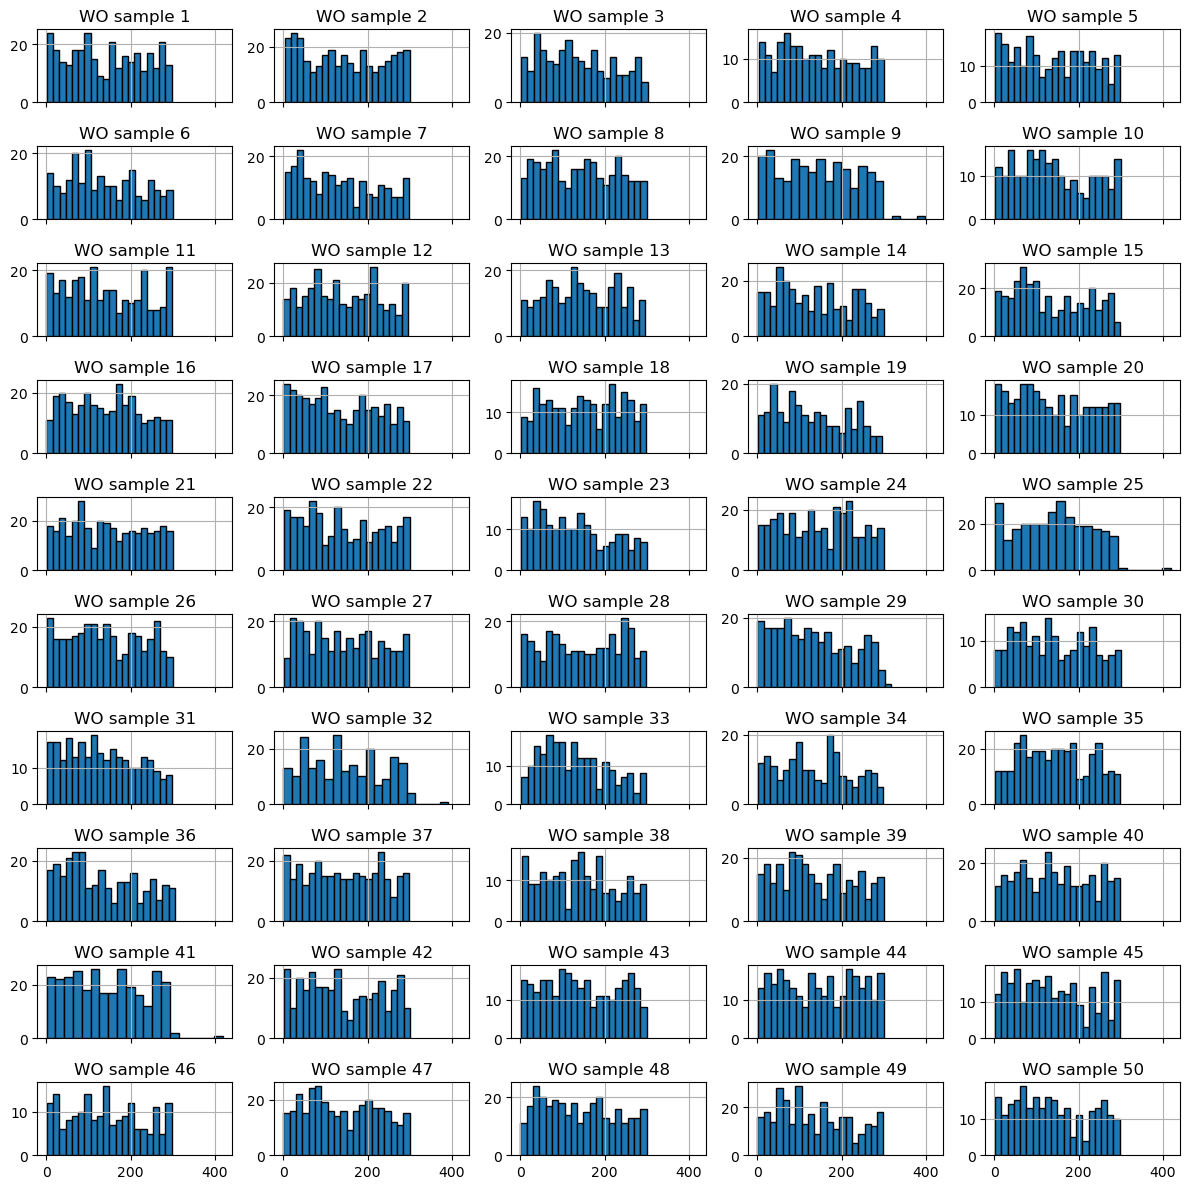

In [6]:
nrow = 10
ncol = 5

fig, axes = plt.subplots(nrow, ncol, figsize=(12,12), sharex=True)
ax_flat = axes.flatten()

txt = 'WO sample'
for ax, sample_index in zip(ax_flat, list(range(nrow*ncol))): 
    selected_sample = data_samples_wo[sample_index]
    ax.hist(selected_sample, bins=20, edgecolor='black')
    ax.set_title(f'{txt} {sample_index+1}')
    ax.grid(True)

plt.tight_layout()
plt.show();


In [7]:
data_samples_stow = []
add_noise = True

for sample in range(n_stow): 
    n_non_null_points = np.random.randint(non_null_sample_size_range[0], non_null_sample_size_range[1])
    print(f'{n_non_null_points}--')

    shape_stow = np.random.uniform(shape_stow_range[0], shape_stow_range[1])
    loc_stow = np.random.uniform(loc_stow_min, loc_stow_max)
    non_null_points = weibull_min.rvs(c=shape_stow, scale=20, loc=loc_stow, size=n_non_null_points)
    
    if add_noise: 
        n_null_points = np.random.randint(null_sample_size_range[0], null_sample_size_range[1])
        null_points = uniform.rvs(loc=0, scale=noise_max, size=n_null_points)
        print(n_null_points)
        data_samples_stow.append(np.concatenate((null_points, non_null_points), axis=0))
    else: 
        data_samples_stow.append(non_null_points)
        
y_stow = np.ones(shape=n_stow)

46--
234
47--
267
31--
206
41--
258
31--
222
42--
287
31--
156
47--
209
33--
291
46--
193
46--
262
37--
214
45--
188
41--
239
36--
203
44--
284
45--
177
36--
234
34--
152
45--
246
38--
186
36--
263
49--
259
48--
238
40--
297
37--
291
39--
201
44--
178
47--
164
38--
243
46--
169
49--
191
38--
182
37--
187
45--
221
46--
172
31--
172
31--
298
43--
250
35--
244
44--
232
48--
288
47--
229
42--
299
32--
214
41--
156
45--
274
33--
299
42--
215
48--
276
36--
236
39--
253
45--
296
31--
285
30--
248
32--
169
49--
211
34--
158
39--
157
44--
218
42--
242
31--
186
49--
176
45--
232
46--
242
39--
162
45--
265
41--
243
41--
238
44--
203
40--
220
49--
245
31--
264
46--
269
37--
257
36--
179
39--
157
45--
293
33--
227
31--
188
45--
269
44--
222
45--
202
34--
151
30--
178
47--
150
33--
211
38--
173
48--
234
41--
211
33--
179
33--
177
30--
197
37--
230
31--
247
37--
229
34--
236
30--
242
33--
262
42--
238
34--
174
44--
284
36--
244
39--
229
34--
265
46--
171
32--
165
46--
158
46--
271
39--
170
46--
240
3

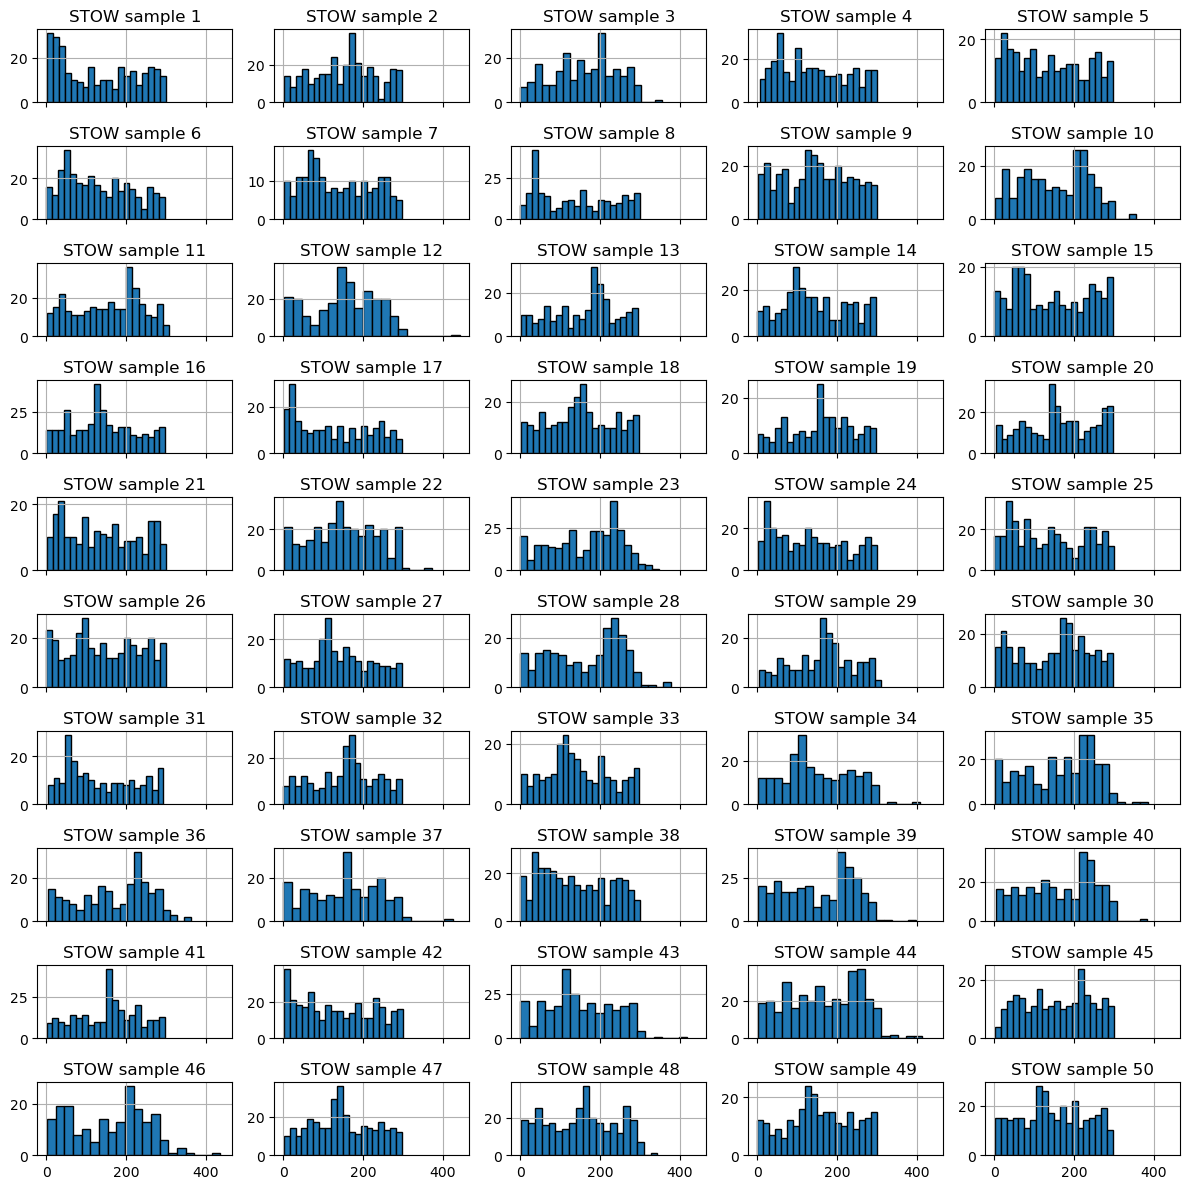

In [8]:
nrow = 10
ncol = 5
fig, axes = plt.subplots(nrow, ncol, figsize=(12,12), sharex=True)
ax_flat = axes.flatten()

txt = 'STOW sample'
for ax, sample_index in zip(ax_flat, list(range(nrow*ncol))): 
    selected_sample = data_samples_stow[sample_index]
    ax.hist(selected_sample, bins=20, edgecolor='black')
    ax.set_title(f'{txt} {sample_index+1}')
    ax.grid(True)

plt.tight_layout()
plt.show();

In [9]:
data_samples = data_samples_wo + data_samples_stow

# FE Approach 01: nan padding

In [10]:
max_n_wo = max([len(sample) for sample in data_samples_wo])
max_n_stow = max([len(sample) for sample in data_samples_stow])
max_obs_per_sample = max([max_n_wo, max_n_stow])

data_samples_padded = (
    [
        np.pad(
            sample, 
            (0, max_obs_per_sample - len(sample)),
            mode='constant', constant_values=np.nan
        ) 
        for sample in data_samples
    ]  
)


X = np.array(data_samples_padded)
y = np.concatenate((y_wo, y_stow), axis=0)

In [11]:
X.shape

(5000, 347)

In [12]:
y.shape

(5000,)

In [13]:
X_train_and_valid, X_test, y_train_and_valid, y_test = train_test_split(X, y, test_size=0.20, random_state=2023)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_and_valid, y_train_and_valid, test_size=0.20, random_state=2023)

In [14]:
X_train.shape

(3200, 347)

In [15]:
X_valid.shape

(800, 347)

In [16]:
model_dict = {
#     0: LogisticRegression(random_state=11), 
#     1: RandomForestClassifier(random_state=11), 
    2: xgb.XGBClassifier(objective="binary:logistic", random_state=11)
}



model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=11, ...)
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       733
         1.0       1.00      0.43      0.60        67

    accuracy                           0.95       800
   macro avg       0.98

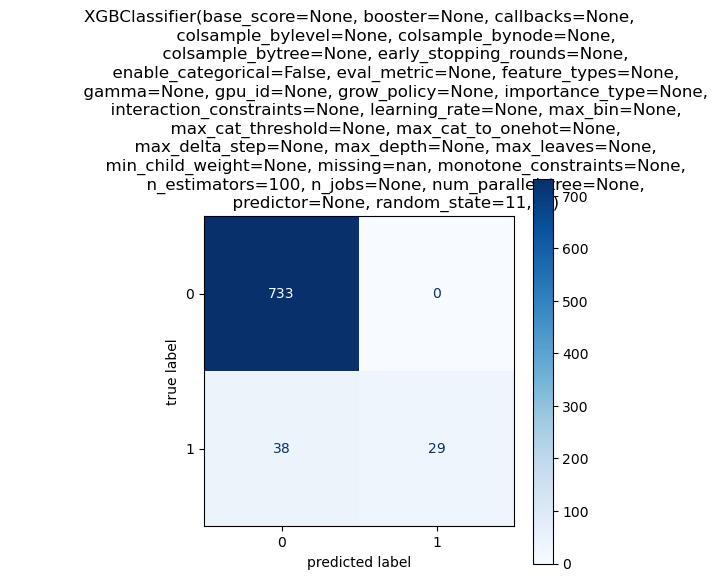

In [17]:
def train_model(model_num, X_train=X_train, y_train=y_train, X_valid=X_valid): 
    m = model_dict.get(model_num)
    m.fit(X_train, y_train)
    preds = m.predict(X_valid)
    return preds 

def evaluate_model(y, y_pred, model_desc=''): 
    cr = classification_report(y, y_pred)
    print(cr) 
    
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title(f'{model_desc}')
    plt.xlabel("predicted label")
    plt.ylabel("true label")
    plt.plot()
    

def train_eval_pipeline(model_num, _X_train=X_train, _y_train=y_train, _X_valid=X_valid, _y_valid=y_valid): 
    model_desc = model_dict.get(model_num)
    print(f'\n\nmodel: {model_desc}')
    preds_valid = train_model(model_num, _X_train, _y_train, _X_valid)
    evaluate_model(_y_valid, preds_valid, model_desc)
    

    
for model in model_dict.keys(): 
    train_eval_pipeline(model)



model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=11, ...)
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       887
         1.0       1.00      0.35      0.51       113

    accuracy                           0.93      1000
   macro avg       0.96

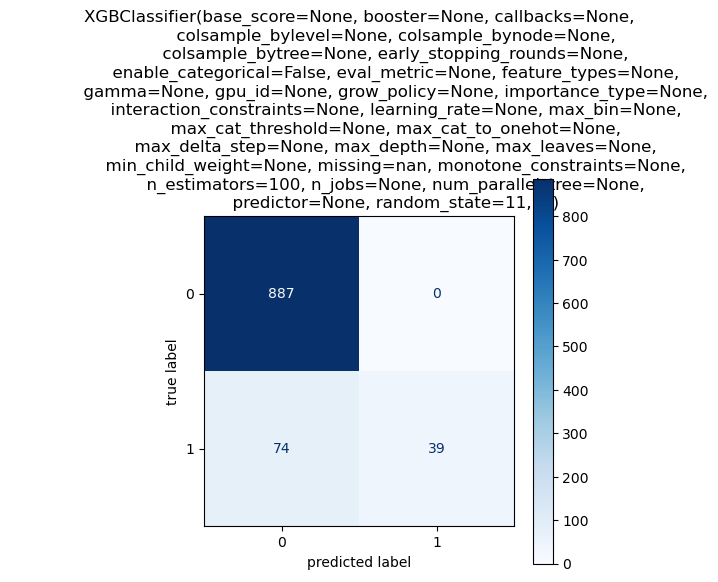

In [18]:
selected_model_num = 2
train_eval_pipeline(selected_model_num, X_train_and_valid, y_train_and_valid, X_test, y_test)

# FE Approach 2: histogram binning 

In [19]:
data_samples_binned = []
for sample in data_samples: 
    hist_values, bin_edges = np.histogram(sample, bins=n_hist_bins)
    data_samples_binned.append(hist_values)

In [20]:
data_samples_binned[:10]

[array([26, 25, 18, 25, 29, 21,  9, 22, 19, 22, 21, 15, 20, 23, 20]),
 array([31, 34, 21, 15, 18, 27, 21, 18, 16, 22, 15, 19, 21, 22, 26]),
 array([19, 12, 26, 17, 15, 24, 18, 14, 18, 13, 11, 13, 11, 17,  8]),
 array([16, 15, 15, 22, 16, 14, 14, 14, 14, 11, 14, 11,  9, 14, 16]),
 array([25, 18, 18, 15, 19, 14, 12, 16, 14, 17, 20, 16, 12, 10, 17]),
 array([16, 14, 14, 24, 22, 15, 16, 14,  9, 18, 14,  8, 13, 11, 13]),
 array([21, 26, 20, 14, 17, 18, 15, 18,  7, 14, 10, 14, 12, 11, 14]),
 array([22, 21, 23, 25, 24, 13, 25, 20, 24, 19, 16, 23, 19, 14, 17]),
 array([27, 24, 16, 26, 20, 24, 20, 23, 13, 22, 18,  4,  1,  0,  1]),
 array([18, 15, 15, 13, 19, 24, 17, 16, 11, 10,  8, 12, 13, 12, 16])]

In [21]:
X = np.vstack(data_samples_binned)
X.shape

(5000, 15)

In [22]:
y.shape

(5000,)

In [23]:
X_train_and_valid, X_test, y_train_and_valid, y_test = train_test_split(X, y, test_size=0.20, random_state=2023)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_and_valid, y_train_and_valid, test_size=0.20, random_state=2023)

In [24]:
X_train.shape

(3200, 15)

In [25]:
X_valid.shape

(800, 15)

In [26]:
model_dict = {
    0: LogisticRegression(random_state=11), 
    1: RandomForestClassifier(random_state=11), 
    2: xgb.XGBClassifier(objective="binary:logistic", random_state=11)
}



model: LogisticRegression(random_state=11)
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       733
         1.0       1.00      0.34      0.51        67

    accuracy                           0.94       800
   macro avg       0.97      0.67      0.74       800
weighted avg       0.95      0.94      0.93       800



model: RandomForestClassifier(random_state=11)
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       733
         1.0       0.87      0.70      0.78        67

    accuracy                           0.97       800
   macro avg       0.92      0.85      0.88       800
weighted avg       0.96      0.97      0.96       800



model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None

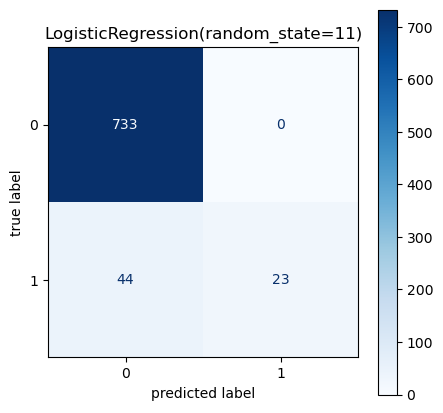

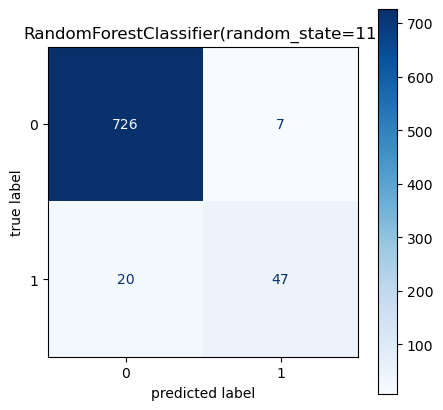

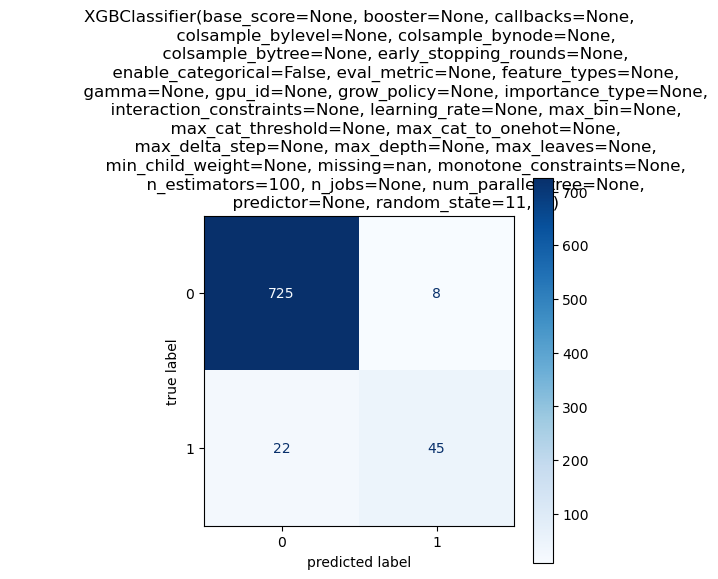

In [27]:
def train_model(model_num, X_train=X_train, y_train=y_train, X_valid=X_valid): 
    m = model_dict.get(model_num)
    m.fit(X_train, y_train)
    preds = m.predict(X_valid)
    return preds 

def evaluate_model(y, y_pred, model_desc=''): 
    cr = classification_report(y, y_pred)
    print(cr) 
    
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title(f'{model_desc}')
    plt.xlabel("predicted label")
    plt.ylabel("true label")
    plt.plot()
    

def train_eval_pipeline(model_num, _X_train=X_train, _y_train=y_train, _X_valid=X_valid, _y_valid=y_valid): 
    model_desc = model_dict.get(model_num)
    print(f'\n\nmodel: {model_desc}')
    preds_valid = train_model(model_num, _X_train, _y_train, _X_valid)
    evaluate_model(_y_valid, preds_valid, model_desc)
    

    
for model in model_dict.keys(): 
    train_eval_pipeline(model)



model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=11, ...)
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       887
         1.0       0.93      0.65      0.77       113

    accuracy                           0.95      1000
   macro avg       0.94

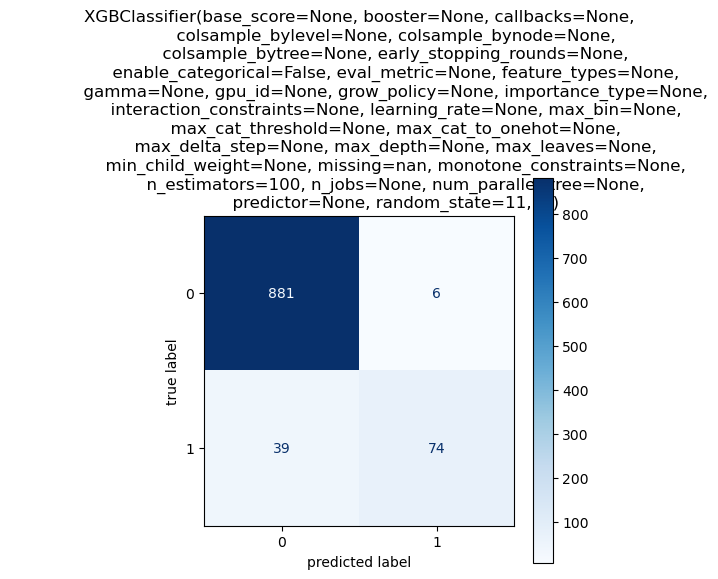

In [28]:
selected_model_num = 2
train_eval_pipeline(selected_model_num, X_train_and_valid, y_train_and_valid, X_test, y_test)